# Feature Analysis for Hot Strip Mill Process Optimization

## Abstract

This notebook addresses the cobbles (german: Hochgeher) phenomenon in hot strip mill operations - a critical quality issue where the strip lifts or buckles during rolling. Understanding and predicting this behavior requires analyzing the complex interplay of numerous process parameters including rolling forces, temperatures, material properties, and mill settings.

**Challenge**: Modern hot strip mills generate data from hundreds to thousands of sensors and process variables. When all parameters are included in a predictive model, the result becomes computationally expensive, statistically unstable, and practically uninterpretable. The presence of multicollinearity (correlated features) further degrades model performance and obscures true cause-effect relationships.

**Objective**: Develop a systematic, statistically sound methodology to reduce a large feature set to a manageable subset of relevant, independent predictors that maintain predictive power while improving model interpretability.

**Approach**: This notebook demonstrates a **progressive filtering strategy** with increasing sophistication:

1. **Basic filtering**: Remove constant features and features with excessive missing data
2. **Data type handling**: Address non-numerical data through encoding or removal
3. **Correlation analysis**: Eliminate pairwise redundancy using Pearson correlation
4. **Variance Inflation Factor (VIF)**: Detect and remove complex multicollinearity patterns
5. **Lasso regression**: Apply L1 regularization for final feature selection based on predictive relevance

Each method is grounded in statistical theory and implemented using standard Python libraries (pandas, scikit-learn, numpy). The notebook emphasizes both theoretical understanding and practical application, making it suitable for process engineers and data scientists working on industrial root cause analysis.

**Target Variable**: `aim_Rollforce_Difference_F1` - the deviation in rolling force at the first stand, which is related to the cobbles phenomenon.

---

## Implementation Notes

This notebook is designed for **educational purposes** in process-oriented root cause analysis. It focuses on linear modeling approaches with one-hot-encoding for categorical variables. All methods are part of fundamental statistical practice and are extensively documented in the linked Python package documentation and academic literature.


The given data is used from production data but scaled or obfuscated and selected to prevent backtracing the actual production data.


A good resource for the statistical methodology can be found at [Stanford University](https://www.stat.cmu.edu/~ryantibs/advmethods/notes/highdim.pdf) and [Medium](https://medium.com/@abhilashagulhane111/data-science-topic-l1-vs-l2-regularization-in-linear-regression-9bb29cfbd2c7).

*P.S.: The python package [pandas](https://pandas.pydata.org) is heavily used in this notebook. Even though it might not always provide the highest computational efficiency, it has proven to be very useful especially for process engineers. The heart of pandas are Dataframes, which are a common datatype also in data engineering and especially the data selection is quite intuitive when coming from spreadsheets such as Microsoft Excel. In this notebook only basic features are employed. For questions regarding dataframes consult the official documentation or online ressources as they are very common.*

In [4]:
import pandas as pd # Dataframes are the central component in the data analyses
import sys # used for progress output
import datetime 
import numpy as np
import warnings
from sklearn.linear_model import LinearRegression # used to calculation the correlation between individual properties
from sklearn.metrics import r2_score # correlation coefficient
import matplotlib.pyplot as plt

datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# ingore some pandas performance warnings, which are not relevant here
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Configuration

A well structured notebook allows better reusablity of it. One key aspect is defining behaviour determining properties in the beginning of the document.

In [5]:
# Dataset used in this study
FILENAMES = ['data/comp_eng_amb_hsm_part1.csv', 'data/comp_eng_amb_hsm_part2.csv', 'data/comp_eng_amb_hsm_part3.csv']

# File containing list of low cardinality variables
LOW_CARDINALITY_FILE = 'data/comp_eng_low_cardinality_vars.txt'

# Target variable that models are trained to
# It is known that cobbles are highly linked to the difference of measured and targeted rollforce in the first finishing line stand F1
TARGET = 'target_param'

# Threshold of required percentage of rows that need to be filled for a column to be considered
MISSING_DATA_THRESHOLD = 0.3

# Threshold above which two columns are correlated too strongly, such that the second column is dumped
CORRELATION_THRESHOLD = 0.8

# threshold for variance inflaction factor above which columns are neglected
VIF_THRESHOLD = 10

# Data loading

In [6]:
# Load data from multiple CSV files and concatenate them
dfs = []
for filename in FILENAMES:
    print(f"Loading {filename}...")
    dfs.append(pd.read_csv(filename))

df = pd.concat(dfs, ignore_index=True)
print(f"Total rows loaded: {len(df)}")
df_org = df.copy()
assert TARGET in df.columns, f"Target variable {TARGET} not found in dataset columns."
display(df.head())
display(df.shape)

Loading data/comp_eng_amb_hsm_part1.csv...
Loading data/comp_eng_amb_hsm_part2.csv...
Loading data/comp_eng_amb_hsm_part3.csv...
Total rows loaded: 8133


,param_1,param_2,param_3,param_4,param_5,param_6,param_7,param_8,param_9,param_10,...,param_2594,param_2595,param_2596,param_2597,param_2598,param_2599,param_2600,param_2601,param_2602,param_2603
0,0.349255,6,0.028362,-1.541673,0.519732,0.348568,0.592072,-1.590322,0.079055,0.063128,...,-0.570362,-0.262530,-0.167582,-0.171375,-0.171194,-0.199633,-0.218227,-0.233079,-0.242238,-0.249397
1,0.849040,6,0.727815,-1.556895,1.307696,0.859693,1.141397,-1.590322,0.079055,0.063128,...,-1.554253,-1.355432,-1.248761,-1.147680,-1.147550,-1.139525,-1.139056,-1.142136,-1.144930,-1.148097
2,0.803140,6,0.739622,-0.264055,0.905242,0.802159,0.686021,-0.326877,0.079055,0.063128,...,-1.571978,-1.372877,-1.302839,-1.311114,-1.310993,-1.336402,-1.355566,-1.371787,-1.383374,-1.393207
3,1.159675,6,1.198041,-0.293718,1.428011,1.158465,1.287504,-0.326776,0.079055,0.063128,...,-1.614589,-1.576933,-1.563149,-1.595579,-1.595472,-1.615700,-1.630988,-1.644422,-1.652808,-1.658547
4,0.900274,6,0.475795,-0.284871,0.616602,0.898766,0.332354,-0.326885,0.079055,0.063128,...,-1.609353,-1.517609,-1.485089,-1.510354,-1.510243,-1.533928,-1.549340,-1.563308,-1.573403,-1.580732


(8133, 2604)

# Filtering

In analyses where hundreds or thousands of parameters are initially considered, a direct regression model will be difficult to interpret. 
Therefore, it makes sense to drop obvious properties from the evaluation. 
In this approach, the methods are getting more sophisticated and will require more computational time due to their complexity. Therefore, the order is also chosen with increasing computational complexity. 

## Constant data
Constant data can be removed, because it will not contribute to the target.

In [7]:
df_before = df.copy()
df = df.loc[:, df.nunique() > 1]
display(df.shape)

CONSTANT_COLUMNS = [col for col in df_before.columns if col not in df.columns]
print(f"Number of constant columns removed: {len(CONSTANT_COLUMNS)}, {df.shape[1]} columns remain.")

(8133, 1797)

Number of constant columns removed: 807, 1797 columns remain.


## Few data

Columns with too many missing data contain insufficient data to give insight with respect to the target and are removed.

In [8]:
df_before = df.copy()
threshold = MISSING_DATA_THRESHOLD * len(df)
df = df.loc[:, df.count() >= threshold] # type: ignore
# missing_cols = [col for col in df.columns if df[col].isna().mean() > missing_threshold]
display(df.shape)

FEW_DATA_COLUMNS = [col for col in df_before.columns if col not in df.columns]
print(f"Number of columns with few data removed: {len(FEW_DATA_COLUMNS)}, {df.shape[1]} columns remain.")

(8133, 1794)

Number of columns with few data removed: 3, 1794 columns remain.


## Non-numerical data
The current approach of linear regression (applied later) can only consider numerical data. Therefore, non-numerical columns must be removed or converted to numerical data.

In this case, One-Hot-Encoding is employed, which adds another binary column for each value in a categorical column. Only one of these additional columns can be 1, while the rest is zero. This way, one category can be activated.

**Example**
Having a property `grade` with 5 possible values `gradeA`, `gradB`, `gradeC`, `gradeD` or `gradeE` will be transformed removing the `grade` column and adding 5 binary columns `gradeA` to `gradeE`. If a row had the value `gradeA` in the `grade` column, `gradeA` will now contain 1, while `gradeB` to `gradeE` will be 0. This way, a numerical value can be integrated into a regression.

In [9]:
df.dtypes.value_counts()

float64    1699
int64        89
object        6
Name: count, dtype: int64

In [10]:
# Identify non-numerical columns. These were prepared earlier to make this analysis more concise.
with open(LOW_CARDINALITY_FILE, 'r') as f:
    non_numerical_cols = f.read().splitlines()

non_numerical_cols = [col for col in non_numerical_cols if col in df.columns]

In [11]:
# Apply one-hot encoding to non-numerical columns

column_count_before = df.shape[1]
df = pd.get_dummies(df, columns=non_numerical_cols, drop_first=True)

column_count_after = df.shape[1]
print(f"Number of columns added by one-hot encoding: {column_count_after - column_count_before}, {df.shape[1]} columns remain.")

Number of columns added by one-hot encoding: 86, 1880 columns remain.


# Correlation Analysis

## Theoretical Background

**Multicollinearity** occurs when predictor variables in a regression model are highly correlated with each other. This creates several problems:

1. **Coefficient instability**: Small changes in the data can lead to large changes in the estimated coefficients
2. **Inflated standard errors**: Makes it difficult to determine which predictors are statistically significant
3. **Reduced interpretability**: Difficult to isolate the individual effect of each predictor on the target variable

The pandas [`.corr()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) method computes the pairwise correlation to evaluate this. It allows for three different correlation methods: `pearson`, `kendall`and `spearman`. Here, we use the default `pearson` option.

## Pearson Correlation Coefficient

The **Pearson correlation coefficient** measures the linear relationship between two variables $X$ and $Y$:

$$r_{XY} = \frac{\sum_{i=1}^{n}(X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^{n}(X_i - \bar{X})^2}\sqrt{\sum_{i=1}^{n}(Y_i - \bar{Y})^2}}$$

Alternatively expressed as:

$$r_{XY} = \frac{\text{Cov}(X,Y)}{\sigma_X \sigma_Y}$$

where:
- $\bar{X}$ and $\bar{Y}$ are the arithmetic means of $X$ and $Y$
- $\text{Cov}(X,Y)$ is the covariance between $X$ and $Y$
- $\sigma_X$ and $\sigma_Y$ are the standard deviations of $X$ and $Y$

**Interpretation:**
- $r = 1$: Perfect positive linear correlation
- $r = 0$: No linear correlation
- $r = -1$: Perfect negative linear correlation
- $|r| > 0.8$: Strong correlation (commonly used threshold), configured at the top of this notebook

## Approach

Strongly correlated features contain redundant information. When two columns are perfectly correlated, they cause issues in the regression model because the model cannot reliably determine which feature to attribute the effect to and with what weight.

**Strategy**: We iterate through all column pairs and keep only those features that do not correlate above a threshold with any already-selected column. This greedy approach progressively builds a set of relatively independent features by:

1. Computing the correlation matrix for all features
2. Iterating through feature pairs
3. When correlation $|r_{ij}| >$ threshold, removing one of the two features (here: always keep the first)
4. Retaining features that maintain correlation below the threshold

In [12]:
# At first, we need to remove the target column from the list of columns to prevent self-correlation
COLUMNS = df.columns.tolist()
COLUMNS.remove(TARGET)
len(COLUMNS)

# Calculation of the pearson correlation matrix and build the absolute values. 
# At this point we do not care about the sign of the correlation, only its magnitude.
# to prevent later typing issues, we convert the matrix to float type
corr_matrix = df[COLUMNS].corr().abs().astype(float)

In [13]:
# Find columns to remove based on correlation threshold
CORRELATED_COLUMNS = set()

for i in range(len(COLUMNS)):
    if COLUMNS[i] in CORRELATED_COLUMNS:
        continue
    sys.stdout.write(f"\rProcessing column {COLUMNS[i]} ({i + 1} of {len(COLUMNS)})\t\t\t\t\t\t\t\t\t\t\t\t")
    for j in range(i + 1, len(COLUMNS)):
        if COLUMNS[j] in CORRELATED_COLUMNS:
            continue
        
        # Check if correlation exceeds threshold
        if corr_matrix.iloc[i, j] > CORRELATION_THRESHOLD:
            CORRELATED_COLUMNS.add(COLUMNS[j])

# Convert to list for easier inspection
CORRELATED_COLUMNS = list(CORRELATED_COLUMNS)
print(f"\nNumber of columns to remove: {len(CORRELATED_COLUMNS)}")
print(f"Remaining columns: {len(COLUMNS) - len(CORRELATED_COLUMNS)}")

Processing column param_81_4 (1848 of 1879)																					
Number of columns to remove: 1507
Remaining columns: 372


In [14]:
# Remove highly correlated columns from df_reg
df_reg = df.drop(columns=CORRELATED_COLUMNS)
print(f"Remaining columns: {df_reg.shape[1]}, {df.shape[1]} columns before.")

Remaining columns: 373, 1880 columns before.


# Variance Inflation Factor (VIF) Analysis

## Theoretical Background

While correlation analysis detects **pairwise linear relationships** between features, it fails to capture more complex multicollinearity where a feature can be predicted by a **combination of multiple other features**. The **Variance Inflation Factor (VIF)** addresses this limitation by quantifying how much the variance of a regression coefficient is inflated due to multicollinearity with all other predictors.

### Mathematical Definition

For a given predictor variable $X_i$ in a multiple regression model, the VIF is defined as:

$$VIF_i = \frac{1}{1 - R^2_i}$$

where $R^2_i$ is the coefficient of determination obtained by regressing $X_i$ against all other predictor variables:

$$X_i = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_{i-1} X_{i-1} + \beta_{i+1} X_{i+1} + ... + \beta_p X_p + \epsilon$$

**Interpretation of $R^2_i$:**
- If $R^2_i = 0$: $X_i$ is completely independent of other predictors → $VIF_i = 1$
- If $R^2_i = 0.9$: 90% of $X_i$'s variance is explained by other predictors → $VIF_i = 10$
- If $R^2_i \to 1$: $X_i$ is almost perfectly predicted by other predictors → $VIF_i \to \infty$

### VIF Interpretation Guidelines

The following thresholds are commonly used in statistical literature:

- **VIF = 1**: No multicollinearity (predictor is orthogonal to others)
- **VIF < 5**: Low to moderate multicollinearity (generally acceptable)
- **5 ≤ VIF < 10**: Moderate to high multicollinearity (consider removal)
- **VIF ≥ 10**: Severe multicollinearity (removal recommended)

Some conservative approaches use a threshold of VIF > 5, while more lenient approaches accept VIF up to 10. Here, 10 is chosen since there are additional decision methods applied.

### Why VIF is Superior to Pairwise Correlation

Consider three variables: $X_1$, $X_2$, and $X_3$, where:
- $X_1$ and $X_2$ have correlation $r = 0.6$ (moderate)
- $X_1$ and $X_3$ have correlation $r = 0.6$ (moderate)
- $X_2$ and $X_3$ have correlation $r = 0.6$ (moderate)

Pairwise correlation analysis might keep all three features since none exceed a threshold of 0.8. However, $X_1$ could still be **highly predictable** from the combination of $X_2$ and $X_3$ together, resulting in $R^2 > 0.9$ and thus $VIF > 10$. VIF detects this **joint multicollinearity**.

The VIF directly quantifies variance inflation. If the variance of the coefficient $\hat{\beta}_i$ in a model without multicollinearity is $\sigma^2_{\hat{\beta}_i}$, then with multicollinearity it becomes:

$$\text{Var}(\hat{\beta}_i) = VIF_i \times \sigma^2_{\hat{\beta}_i}$$

Thus, $VIF_i = 10$ means the variance (and standard error) of $\hat{\beta}_i$ is inflated by a factor of 10, making hypothesis tests less powerful and confidence intervals wider.

## Iterative VIF-Based Feature Selection

Since removing one high-VIF feature can affect the VIF values of remaining features, we use an **iterative approach**:

1. Calculate VIF for all features
2. Identify the feature with the highest VIF
3. If $VIF_{max} >$ threshold, remove that feature
4. Recalculate VIF for remaining features
5. Repeat until all $VIF \leq$ threshold

This greedy algorithm ensures that the final feature set has controlled multicollinearity.

In [15]:
def calculate_vif(df, features):
    """Calculate VIF for each feature"""
    vif_data = []
    
    for i, target_feature in enumerate(features):
        # Get all other features
        X_others = df[features].drop(columns=[target_feature])
        y_feature = df[target_feature]
        
        # Handle missing values
        mask = ~(X_others.isna().any(axis=1) | y_feature.isna())
        X_clean = X_others[mask]
        y_clean = y_feature[mask]
        
        if len(X_clean) == 0:
            vif = np.nan
        else:
            # Fit linear regression
            lr = LinearRegression()
            lr.fit(X_clean, y_clean)
            r2 = r2_score(y_clean, lr.predict(X_clean))
            
            # Calculate VIF
            vif = 1 / (1 - r2) if r2 < 0.9999 else np.inf
        
        vif_data.append({'Feature': target_feature, 'VIF': vif})
    
    return pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

def remove_high_vif_features(df, features, threshold=10, max_iterations=100):
    """Iteratively remove features with VIF above threshold"""
    remaining_features = features.copy()
    iteration = 0
    
    while iteration < max_iterations:
        iteration += 1
        n_features = len(remaining_features)
        
        # Calculate VIF for remaining features with progress bar
        vif_data = []
        for i, target_feature in enumerate(remaining_features):
            percentage = int(((i + 1) / n_features) * 100)
            bar_length = 40
            filled_length = int(bar_length * (i + 1) / n_features)
            bar = '█' * filled_length + '-' * (bar_length - filled_length)
            sys.stdout.write(f"\rIteration {iteration} - {n_features} features : [{bar}] {percentage}%")
            sys.stdout.flush()
            
            # Calculate VIF for this feature
            X_others = df[remaining_features].drop(columns=[target_feature])
            y_feature = df[target_feature]
            
            # Handle missing values
            mask = ~(X_others.isna().any(axis=1) | y_feature.isna())
            X_clean = X_others[mask]
            y_clean = y_feature[mask]
            
            if len(X_clean) == 0:
                vif = np.nan
            else:
                lr = LinearRegression()
                lr.fit(X_clean, y_clean)
                r2 = r2_score(y_clean, lr.predict(X_clean))
                vif = 1 / (1 - r2) if r2 < 0.9999 else np.inf
            
            vif_data.append({'Feature': target_feature, 'VIF': vif})
        
        vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)
        
        # Find max VIF
        max_vif = vif_df['VIF'].max()
        
        if max_vif <= threshold or np.isnan(max_vif):
            sys.stdout.write(f"\rIteration {iteration} - {n_features} features : All VIF <= {threshold}             \n")
            sys.stdout.flush()
            break
        
        # Remove feature with highest VIF
        feature_to_remove = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
        sys.stdout.write(f"\rIteration {iteration} - {n_features} features : Max VIF = {max_vif:.2f}, removing '{feature_to_remove[:40]}'\t\t\t\t\t\t\t\t\n")
        sys.stdout.flush()
        remaining_features.remove(feature_to_remove)
    
    return remaining_features

In [16]:
# Iteratively remove features with highest VIF until all are below threshold
# Apply VIF filtering
COLUMNS = df_reg.columns.to_list()
COLUMNS.remove(TARGET)
filtered_columns = remove_high_vif_features(df_reg, COLUMNS, VIF_THRESHOLD)
print(f"\nOriginal features: {len(COLUMNS)}")
print(f"Remaining features: {len(filtered_columns)}")
print(f"Removed: {len(COLUMNS) - len(filtered_columns)}")

Iteration 1 - 372 features : Max VIF = inf, removing 'param_145'								100%
Iteration 2 - 371 features : Max VIF = inf, removing 'param_146'								100%
Iteration 3 - 370 features : Max VIF = inf, removing 'param_147'								100%
Iteration 4 - 369 features : Max VIF = inf, removing 'param_950'								100%
Iteration 5 - 368 features : Max VIF = inf, removing 'param_2409'								00%
Iteration 6 - 367 features : Max VIF = inf, removing 'param_1621_22'								
Iteration 7 - 366 features : Max VIF = inf, removing 'param_1882_1005'								
Iteration 8 - 365 features : Max VIF = inf, removing 'param_779'								100%
Iteration 9 - 364 features : Max VIF = inf, removing 'param_2383'								00%
Iteration 10 - 363 features : Max VIF = inf, removing 'param_2354_langzeit'								
Iteration 11 - 362 features : Max VIF = inf, removing 'param_846'								100%
Iteration 12 - 361 features : Max VIF = inf, removing 'param_1621_217'								
Iteration 13 - 360 features : Max VIF = 4524.43, removing 'param

In [17]:
df_vif = df_reg[filtered_columns + [TARGET]]
df_vif.shape

(8133, 279)

# Lasso Regression for Feature Selection

## Theoretical Background

While correlation analysis and VIF focus on **removing redundant features** due to multicollinearity, they do not assess whether features are actually **relevant for predicting the target variable**. A feature might be independent of all other features (low correlation, low VIF) but still have no predictive value for the target. Conversely, we might remove a highly correlated feature that is actually important for prediction.

**Lasso (Least Absolute Shrinkage and Selection Operator)** regression addresses this by performing **embedded feature selection** - it simultaneously fits a regression model and identifies the most predictive features based on their relationship with the target variable.

## Mathematical Formulation

Lasso regression solves the following optimization problem:

$$\min_{\beta} \left\{ \frac{1}{2n}\sum_{i=1}^{n}(y_i - \beta_0 - \sum_{j=1}^{p}\beta_j x_{ij})^2 + \lambda\sum_{j=1}^{p}|\beta_j| \right\}$$

This can be decomposed into two components:

1. **Residual Sum of Squares (RSS)**: $\frac{1}{2n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$ - measures prediction error (as in ordinary least squares)

2. **L1 Penalty**: $\lambda\sum_{j=1}^{p}|\beta_j|$ - penalizes the absolute values of coefficients

where:
- $y_i$ = target variable (observed value for observation $i$)
- $\beta_0$ = **intercept** (constant term) - the predicted value when all features equal zero
- $\beta_1, \beta_2, ..., \beta_p$ = **slope coefficients** for each feature
- $x_{ij}$ = value of feature $j$ for observation $i$
- $n$ = number of observations
- $p$ = number of features

**Important**: The intercept $\beta_0$ is **not included in the L1 penalty** $\lambda\sum_{j=1}^{p}|\beta_j|$. Only the slope coefficients are penalized. This is standard practice because the intercept simply shifts predictions and doesn't affect model complexity. When features are standardized (mean = 0), the intercept represents the mean of the target variable.

The parameter $\lambda \geq 0$ controls the strength of regularization:
- $\lambda = 0$: Equivalent to ordinary least squares regression (no feature selection)
- $\lambda \to \infty$: All coefficients are shrunk to zero (null model)
- $0 < \lambda < \infty$: Trade-off between model fit and model complexity

## Key Property: Automatic Feature Selection

The crucial property of the L1 penalty is that it produces **sparse solutions** - many coefficients are set **exactly to zero**. This differs from L2 regularization (Ridge regression), which shrinks coefficients toward zero but rarely sets them exactly to zero.

**Geometric Interpretation**: The constraint region of L1 regularization is a diamond (in 2D) or hypercube (in higher dimensions) with corners on the axes. As the optimization moves toward the constraint boundary, it tends to hit these corners where entire coefficients become zero.

## Why Lasso After VIF?

The combination of VIF filtering followed by Lasso provides complementary benefits:

1. **VIF removes multicollinearity** → Improves Lasso stability and interpretability
2. **Lasso removes irrelevant features** → Focuses on predictive power for the target
3. **Computational efficiency** → VIF reduces feature space, making Lasso faster
4. **Statistical robustness** → VIF ensures remaining features have independent information

This sequential approach creates a final feature set that is:
- **Independent** (low multicollinearity from VIF)
- **Relevant** (high predictive value from Lasso)
- **Interpretable** (small number of features)
- **Stable** (reliable coefficient estimates)

## Cross-Validation and the One-Standard-Error Rule

Selecting the optimal $\lambda$ requires balancing model performance and simplicity. We use:

1. **K-Fold Cross-Validation**: Split data into K folds, train on K-1 folds, validate on the remaining fold, and repeat. This estimates out-of-sample prediction error for different $\lambda$ values.

2. **One-Standard-Error Rule**: Instead of choosing $\lambda$ that minimizes cross-validation error (which may overfit), we choose the largest $\lambda$ (simplest model) whose error is within one standard error of the minimum. This favors parsimony and improves generalization.

The rule is: 

$$\lambda_{1SE} = \max\{\lambda : \text{CV-Error}(\lambda) \leq \text{CV-Error}(\lambda_{min}) + SE(\lambda_{min})\}$$

This produces more interpretable models with slightly lower complexity at minimal cost to prediction accuracy.

## Feature Standardization

**Critical requirement**: Features must be standardized (zero mean, unit variance) before applying Lasso. The L1 penalty $\sum|\beta_j|$ treats all coefficients equally, so features with larger scales would artificially receive larger penalties. Standardization ensures features compete fairly for inclusion in the model.

## Literature References

- **Tibshirani, R. (1996)**. "Regression Shrinkage and Selection via the Lasso". *Journal of the Royal Statistical Society: Series B (Methodological)*, 58(1), 267-288.
  - Original paper introducing Lasso regression and proving its feature selection properties

- **Hastie, T., Tibshirani, R., & Friedman, J. (2009)**. *The Elements of Statistical Learning: Data Mining, Inference, and Prediction* (2nd ed.). Springer.
  - Comprehensive treatment of Lasso in Chapter 3 (Linear Methods) and Chapter 18 (High-Dimensional Problems), including geometric interpretation and practical implementation

In [ ]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler

LAMBDA_EXTRA_FACTOR = 1.0  # One-standard-error rule factor

# Prepare data for Lasso regression
X = df_vif.drop(columns=[TARGET])
y = df_vif[TARGET]

# Handle missing values
mask = ~(X.isna().any(axis=1) | y.isna())
X_clean = X[mask]
y_clean = y[mask]

print(f"Data shape after removing missing values: {X_clean.shape}")

# Standardize features (important for Lasso)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Use cross-validation to find the best lambda (alpha in sklearn)
# We use 10-fold cross-validation
print("Performing Lasso cross-validation to find optimal lambda...")
lasso_cv = LassoCV(
    cv=10,
    random_state=42,
    max_iter=10000,
    n_jobs=-1
)
lasso_cv.fit(X_scaled, y_clean)

# Get best alpha and standard error
best_alpha = lasso_cv.alpha_
alphas = lasso_cv.alphas_
mse_path = lasso_cv.mse_path_.mean(axis=1)
std_error = lasso_cv.mse_path_.std(axis=1) / np.sqrt(10)

# Find index of best alpha
best_idx = np.where(alphas == best_alpha)[0][0]
best_mse = mse_path[best_idx]
best_se = std_error[best_idx]

# Apply one-standard-error rule: find largest alpha within one SE of best
threshold = best_mse + LAMBDA_EXTRA_FACTOR * best_se
valid_alphas = alphas[mse_path <= threshold]
alpha_1se = valid_alphas.max() if len(valid_alphas) > 0 else best_alpha

print(f"Best alpha from CV: {best_alpha:.6f}")
print(f"Alpha using one-standard-error rule: {alpha_1se:.6f}")

# Fit Lasso with the selected alpha
lasso = Lasso(alpha=alpha_1se, random_state=42, max_iter=10000)
lasso.fit(X_scaled, y_clean)

# Identify features with non-zero coefficients
non_zero_coefs = np.abs(lasso.coef_) > 0
selected_features = X_clean.columns[non_zero_coefs].tolist()

print(f"\nOriginal features: {len(X_clean.columns)}")
print(f"Features selected by Lasso: {len(selected_features)}")
print(f"Features removed: {len(X_clean.columns) - len(selected_features)}")

# Create dataframe with selected features plus target
LASSO_COLUMNS = selected_features
df_lasso = df_vif[LASSO_COLUMNS + [TARGET]]

print(f"\nFinal dataframe shape: {df_lasso.shape}")

Data shape after removing missing values: (7135, 278)
Performing Lasso cross-validation to find optimal lambda...
Best alpha from CV: 0.007703
Alpha using one-standard-error rule: 0.020460

Original features: 278
Features selected by Lasso: 64
Features removed: 214

Final dataframe shape: (8133, 65)


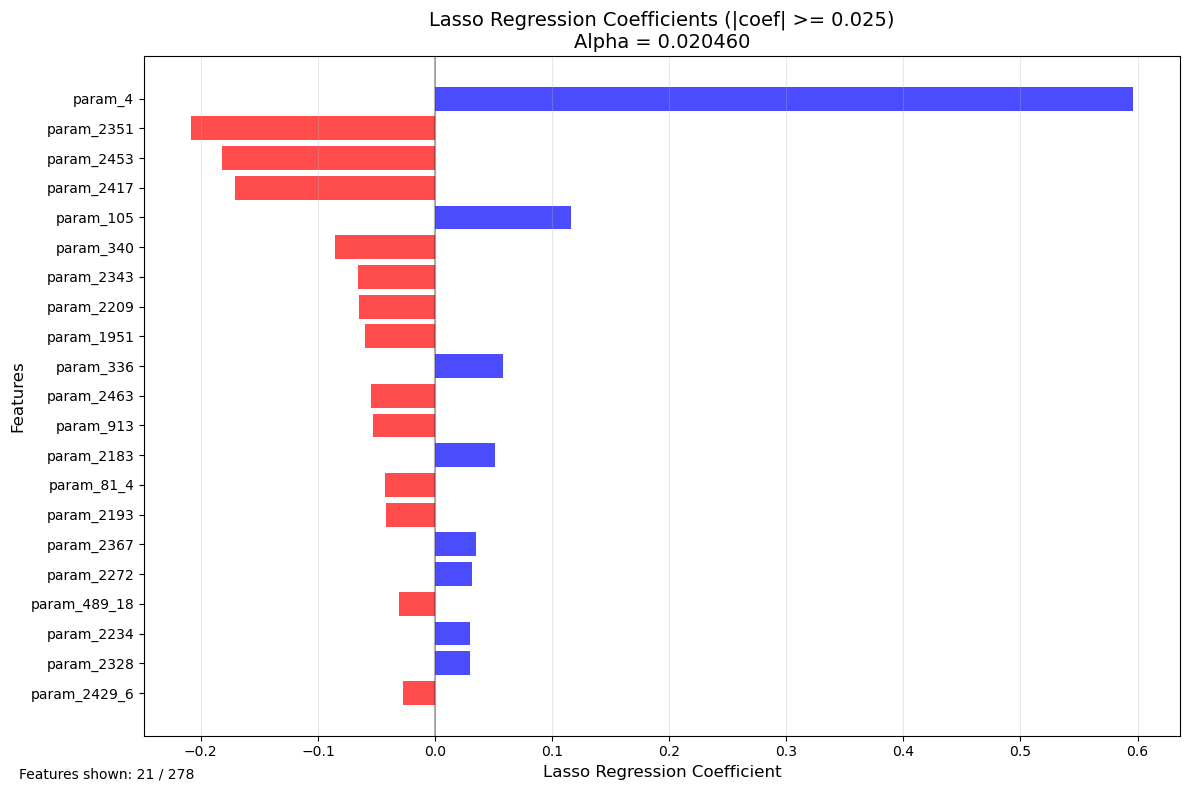

Features with |coefficient| >= 0.025: 21
Features with coefficient = 0: 214
Total features after VIF filtering: 278


In [19]:
# Define cutoff threshold for visualization
WEIGHT_CUTOFF = 0.025  # Adjust this value to filter small weights

# Get feature names and coefficients from the fitted Lasso model
feature_names = X_clean.columns
coefficients = lasso.coef_

# Create a dataframe for easier manipulation
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=True)

# Filter coefficients above the cutoff threshold
filtered_coef_df = coef_df[coef_df['Abs_Coefficient'] >= WEIGHT_CUTOFF]

# Create the plot
plt.figure(figsize=(12, max(8, len(filtered_coef_df) * 0.3)))
colors = ['red' if x < 0 else 'blue' for x in filtered_coef_df['Coefficient']]

plt.barh(range(len(filtered_coef_df)), filtered_coef_df['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(filtered_coef_df)), filtered_coef_df['Feature'], fontsize=10)
plt.xlabel('Lasso Regression Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title(f'Lasso Regression Coefficients (|coef| >= {WEIGHT_CUTOFF})\nAlpha = {lasso.alpha:.6f}', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='x', alpha=0.3)

# Add text showing number of features
plt.figtext(0.02, 0.02, f'Features shown: {len(filtered_coef_df)} / {len(feature_names)}', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Features with |coefficient| >= {WEIGHT_CUTOFF}: {len(filtered_coef_df)}")
print(f"Features with coefficient = 0: {len(feature_names) - len(selected_features)}")
print(f"Total features after VIF filtering: {len(feature_names)}")

# Fun read: Non-linear models for Feature Selection

# Random Forest Feature Importance Analysis

## Theoretical Background

While the previous linear methods (correlation, VIF, Lasso) are excellent for understanding linear relationships and ensuring model interpretability, they have limitations when dealing with **non-linear relationships** and **interaction effects** between features. **Random Forest** is a powerful ensemble learning method that can:

1. **Capture non-linear relationships** between features and the target
2. **Detect interaction effects** between multiple features
3. **Handle mixed data types** (numerical and categorical) naturally
4. **Provide feature importance** rankings without assuming linearity

Random Forest feature importance serves as a complementary validation method to compare against the linear feature selection approach.

## Random Forest Algorithm

Random Forest builds multiple decision trees on bootstrapped samples of the data and averages their predictions. Each tree is trained on:
- A **random subset of observations** (bootstrap sampling with replacement)
- A **random subset of features** at each split (typically $\sqrt{p}$ features for regression)

This randomization decorrelates the trees and improves generalization.

## Feature Importance Metrics

Random Forest provides two main feature importance measures:

### 1. Mean Decrease in Impurity (MDI) - Gini Importance

For each feature $X_j$, importance is calculated as:

$$I(X_j) = \frac{1}{N_T}\sum_{T}\sum_{t \in T: v(t) = X_j} p(t) \cdot \Delta i(t)$$

where:
- $N_T$ = number of trees in the forest
- $T$ = individual tree
- $t$ = node in tree $T$
- $v(t)$ = feature used for splitting at node $t$
- $p(t)$ = proportion of samples reaching node $t$
- $\Delta i(t)$ = decrease in impurity (MSE for regression) from the split

**Interpretation**: Features that create splits reducing impurity the most across many trees are most important.

**Advantage**: Fast to compute (already calculated during training)

**Limitation**: Can be biased toward high-cardinality features (many unique values)

### 2. Permutation Importance

For each feature $X_j$:
1. Calculate baseline model performance on validation set
2. Randomly shuffle values of $X_j$ (breaking its relationship with target)
3. Calculate new model performance
4. Importance = decrease in performance

$$I_{\text{perm}}(X_j) = \text{Score}_{\text{baseline}} - \text{Score}_{\text{permuted}}$$

**Interpretation**: Features whose random shuffling degrades model performance the most are most important.

**Advantage**: Unbiased, model-agnostic, accounts for feature interactions

**Limitation**: Computationally expensive (requires multiple predictions)

## Comparison with Linear Methods

| Aspect | Linear Methods (Lasso/VIF) | Random Forest |
|--------|---------------------------|---------------|
| **Relationships** | Linear only | Linear + Non-linear |
| **Interactions** | Limited (requires manual feature engineering) | Automatic detection |
| **Interpretability** | High (coefficients have direct meaning) | Moderate (importance scores, not coefficients) |
| **Feature selection** | Explicit (features removed) | Ranking (all features scored) |
| **Multicollinearity** | Must be addressed (VIF) | Naturally robust |
| **Computational cost** | Low to moderate | Moderate to high |

## Use Case: Validation and Discovery

In this analysis, Random Forest serves to:

1. **Validate linear findings**: Do Lasso-selected features also rank highly in Random Forest?
2. **Discover missed features**: Are there important non-linear predictors that linear methods missed?
3. **Understand feature types**: Which features contribute through linear vs. non-linear mechanisms?
4. **Benchmark importance**: Provides an alternative importance metric for comparison

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Prepare data from original dataframe (after handling missing data and non-numerical columns)
# Use df_org but apply same preprocessing steps
df_rf = df_org.copy()

# Remove constant columns
df_rf = df_rf.loc[:, df_rf.nunique() > 1]

# Remove columns with too much missing data
threshold = MISSING_DATA_THRESHOLD * len(df_rf)
df_rf = df_rf.loc[:, df_rf.count() >= threshold]

# Apply one-hot encoding to non-numerical columns
non_numerical_cols_rf = [col for col in non_numerical_cols if col in df_rf.columns]
df_rf = pd.get_dummies(df_rf, columns=non_numerical_cols_rf, drop_first=True)

# Prepare X and y
X_rf = df_rf.drop(columns=[TARGET])
y_rf = df_rf[TARGET]

# Handle missing values
mask_rf = ~(X_rf.isna().any(axis=1) | y_rf.isna())
X_rf_clean = X_rf[mask_rf]
y_rf_clean = y_rf[mask_rf]

print(f"Random Forest data shape: {X_rf_clean.shape}")
print(f"Number of features: {X_rf_clean.shape[1]}")
print(f"Number of samples: {X_rf_clean.shape[0]}")

# Train Random Forest with reasonable hyperparameters
print("\nTraining Random Forest model...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_rf_clean, y_rf_clean)

# Get feature importances (MDI - Mean Decrease in Impurity)
feature_importances = rf_model.feature_importances_

# Create dataframe with feature importances
importance_df = pd.DataFrame({
    'Feature': X_rf_clean.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print(f"\nTop 20 Most Important Features (MDI):")
print(importance_df.head(20))

# Calculate R² score on training data
train_score = rf_model.score(X_rf_clean, y_rf_clean)
print(f"\nRandom Forest R² score on training data: {train_score:.4f}")

Random Forest data shape: (7135, 1879)
Number of features: 1879
Number of samples: 7135

Training Random Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   14.7s



Top 20 Most Important Features (MDI):
         Feature  Importance
2        param_4    0.492449
1586  param_2453    0.042063
1        param_3    0.035747
1434  param_2287    0.030557
1494  param_2351    0.017745
1599  param_2470    0.016502
3        param_5    0.011248
1485  param_2341    0.011115
14      param_16    0.010568
1489  param_2345    0.007524
1376  param_2186    0.007123
1389  param_2210    0.004907
1598  param_2469    0.004588
1484  param_2340    0.003965
4        param_6    0.003950
1404  param_2226    0.003691
30      param_38    0.003653
1537  param_2398    0.003602
0        param_1    0.003355
1584  param_2451    0.002959

Random Forest R² score on training data: 0.8986

Feature importances saved to 'rf_feature_importance_mdi.csv'


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


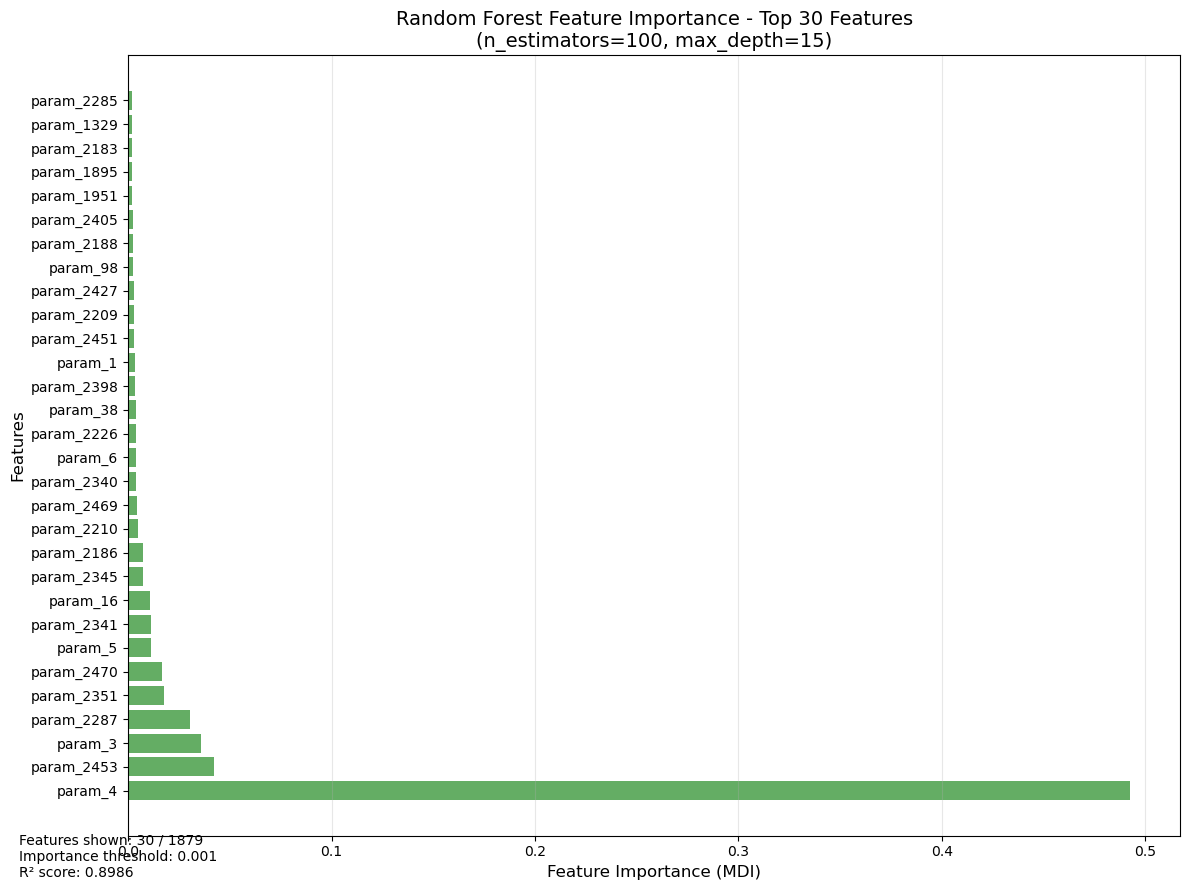


Comparison: Random Forest vs Lasso Feature Selection
Total features after preprocessing: 1879
Features selected by Lasso: 64
Top 30 features by Random Forest importance: 30

Overlap between Lasso and top 30 RF features: 8
Overlap percentage (of Lasso features): 12.5%
Overlap percentage (of top RF features): 26.7%

Common features (alphabetically sorted):
  - param_1951                                                   | Lasso: -0.0594 | RF: 0.002134
  - param_2183                                                   | Lasso:  0.0512 | RF: 0.001965
  - param_2209                                                   | Lasso: -0.0652 | RF: 0.002894
  - param_2351                                                   | Lasso: -0.2083 | RF: 0.017745
  - param_2405                                                   | Lasso:  0.0217 | RF: 0.002437
  - param_2453                                                   | Lasso: -0.1820 | RF: 0.042063
  - param_38                                                

In [21]:
import matplotlib.pyplot as plt

# Define cutoff threshold for visualization
RF_IMPORTANCE_CUTOFF = 0.001  # Adjust this value to filter small importances

# Filter features above the cutoff threshold
filtered_importance_df = importance_df[importance_df['Importance'] >= RF_IMPORTANCE_CUTOFF].copy()

# Take top 30 features for better visualization
top_n = 30
plot_df = filtered_importance_df.head(top_n)

# Create the plot
plt.figure(figsize=(12, max(8, len(plot_df) * 0.3)))
plt.barh(range(len(plot_df)), plot_df['Importance'], color='forestgreen', alpha=0.7)
plt.yticks(range(len(plot_df)), plot_df['Feature'], fontsize=10)
plt.xlabel('Feature Importance (MDI)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title(f'Random Forest Feature Importance - Top {top_n} Features\n(n_estimators=100, max_depth=15)', fontsize=14)
plt.grid(axis='x', alpha=0.3)

# Add text showing statistics
plt.figtext(0.02, 0.02, 
            f'Features shown: {len(plot_df)} / {len(importance_df)}\n'
            f'Importance threshold: {RF_IMPORTANCE_CUTOFF}\n'
            f'R² score: {train_score:.4f}',
            fontsize=10)

plt.tight_layout()
plt.show()

# Print comparison with Lasso-selected features
print(f"\n{'='*60}")
print("Comparison: Random Forest vs Lasso Feature Selection")
print(f"{'='*60}")
print(f"Total features after preprocessing: {len(X_rf_clean.columns)}")
print(f"Features selected by Lasso: {len(LASSO_COLUMNS)}")
print(f"Top {top_n} features by Random Forest importance: {len(plot_df)}")

# Check overlap between Lasso and top RF features
lasso_set = set(LASSO_COLUMNS)
rf_top_set = set(plot_df['Feature'].tolist())
overlap = lasso_set.intersection(rf_top_set)

print(f"\nOverlap between Lasso and top {top_n} RF features: {len(overlap)}")
print(f"Overlap percentage (of Lasso features): {len(overlap)/len(LASSO_COLUMNS)*100:.1f}%")
print(f"Overlap percentage (of top RF features): {len(overlap)/len(plot_df)*100:.1f}%")

if len(overlap) > 0:
    print(f"\nCommon features (alphabetically sorted):")
    for feature in sorted(overlap):
        lasso_coef = coef_df[coef_df['Feature'] == feature]['Coefficient'].values
        rf_imp = importance_df[importance_df['Feature'] == feature]['Importance'].values
        if len(lasso_coef) > 0 and len(rf_imp) > 0:
            print(f"  - {feature[:60]:<60} | Lasso: {lasso_coef[0]:7.4f} | RF: {rf_imp[0]:.6f}")

# Closing comments

The feature selection is usually part of a root cause analyses. The presented methods provide prediction models that help to determine a target such as the rollforce difference. But really understanding why these effects occur must be done with advanced context knowledge. 
Taking the outcome of the feature selection or feature importance, may still be misleading because interactions are usually very complex and difficult to fathom. 

More trust in the results can come from hypotheses tests, that can support the results by testing important prerequisits of the multilinear regression such as normal distribution of features or heteroskedasticity. Adding them to this study makes the study more robust, altough the results are still to be handled with contextual caution. 

While machine learning approaches are more robust towards such prerequirements, interpreting the results is much more difficult. Here, topic such as explainable AI or SHAP values can improve the interpretability of the results